In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weights_file = '/content/drive/MyDrive/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

In [11]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [13]:
from tensorflow.keras.optimizers import RMSprop


x = layers.Flatten()(last_output)

x = layers.Dense(1024, activation='relu')(x)

x = layers.Dropout(0.2)(x)

x = layers.Dense  (1, activation='sigmoid')(x)

model = Model( pre_trained_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [14]:
train_dir='/content/drive/MyDrive/tmp/horse-or-human'
validation_dir ='/content/drive/MyDrive/tmp/validation-horse-or-human'

train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))


validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary',
                                                          target_size = (150, 150))


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [16]:
train_generator.class_indices

{'horses': 0, 'humans': 1}

In [9]:
callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 51,
            epochs = 100,
            validation_steps = 13,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/100
51/51 - 569s - loss: 1.3563 - accuracy: 0.8961 - val_loss: 1.4197e-04 - val_accuracy: 1.0000 - 569s/epoch - 11s/step
Epoch 2/100
51/51 - 15s - loss: 0.0798 - accuracy: 0.9762 - val_loss: 0.0042 - val_accuracy: 0.9961 - 15s/epoch - 287ms/step
Epoch 3/100
51/51 - 14s - loss: 0.0272 - accuracy: 0.9911 - val_loss: 0.0289 - val_accuracy: 0.9961 - 14s/epoch - 274ms/step
Epoch 4/100
51/51 - 14s - loss: 0.0530 - accuracy: 0.9861 - val_loss: 0.0084 - val_accuracy: 0.9961 - 14s/epoch - 279ms/step
Epoch 5/100
51/51 - 14s - loss: 0.0460 - accuracy: 0.9901 - val_loss: 0.0390 - val_accuracy: 0.9922 - 14s/epoch - 276ms/step
Epoch 6/100
51/51 - 14s - loss: 0.0120 - accuracy: 0.9950 - val_loss: 0.0420 - val_accuracy: 0.9922 - 14s/epoch - 272ms/step
Epoch 7/100
51/51 - 14s - loss: 0.0163 - accuracy: 0.9940 - val_loss: 3.3058e-04 - val_accuracy: 1.0000 - 14s/epoch - 275ms/step
Epoch 8/100
51/51 - 14s - loss: 0.0099 - accuracy: 0.9960 - val_loss: 0.0125 - val_accuracy: 0.9961 - 14s/epoch - 275

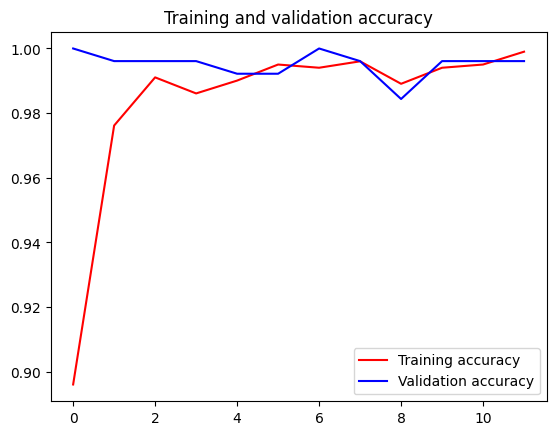

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()